## Accessing ASTER data on Azure

This notebook demonstrates basic access to ASTER data on Azure, using the NASA CMR API to query for tiles, then accessing the tiles on Azure blob storage.

This data set is stored in the West Europe Azure region, so this notebook will run most efficiently on Azure compute located in West Europe.  We recommend that substantial computation depending on this data also be situated in West Europe.  You don't want to download hundreds of terabytes to your laptop!  If you are using this data for environmental science applications, consider applying for an [AI for Earth grant](http://aka.ms/ai4egrants) to support your compute requirements.

### Imports

In [16]:
import re
import os
import datetime
import progressbar
import tempfile
import urllib
import shutil
import numpy as np
import matplotlib.pyplot as plt

import rasterio
from rasterio.windows import Window
from pyproj import Transformer        
from azure.storage.blob import ContainerClient

from cmr import GranuleQuery

### Constants

In [34]:
# Let's take a look at an area in Japan that looks interesting in the VNIR bands
query_lat = 35.08409151423969
query_lon = 138.55814925655318
query_short_name = 'AST_L1T'

query_start_date = datetime.datetime(2002, 1, 1, 0, 0, 0)
query_end_date = datetime.datetime(2004, 12, 1, 0, 0, 0)

# Which image type (SWIR, TIR, VNIR) should we render?
image_type = 'VNIR'

### Azure storage location constants

In [24]:
storage_account_name = 'astersa'
container_name = 'aster'
storage_account_url = \
  'https://' + storage_account_name + '.blob.core.windows.net/'

# Read-only SAS token, provided as part of the container documentation
ro_sas_token = '?sv=2020-04-08&si=aster-ro&sr=c&sig=sXo9shWJec3H6ezpLPuYo7gVpM%2Bj0jLL0fa7jv%2FUe1M%3D'

container_client = ContainerClient(account_url=storage_account_url, 
                                             container_name=container_name, credential=ro_sas_token)

### Search for granules

In [25]:
api = GranuleQuery()
granules = api.short_name(query_short_name).point(query_lon,query_lat).temporal(query_start_date, query_end_date).get()

print('Found {} matching granules'.format(len(granules)))

Found 54 matching granules


### Grab the granule with the lowest cloud cover

In [26]:
# Sort by cloud cover
for granule in granules:
    granule['cloud_cover'] = float(granule['cloud_cover'])
granules = sorted(granules, key=lambda k: k['cloud_cover'])
granule = granules[0]
print(granule['producer_granule_id'])

AST_L1T_00310042002014048_20150425134514_6769


### Prepare the scene prefix

In [28]:
# For the product:
#
# AST_L1T_00301152004192004_20150502205642_77732
#    
# Our path is:
#    
# https://astersa.blob.core.windows.net/aster/images/L1T/2004/01/15/AST_L1T_00301152004192004_20150502205642_77732.hdf
#
# images/L1T/2004/01/15/AST_L1T_00301152004192004_20150502205642_77732.hdf
#

granule_id = granule['producer_granule_id']
assert granule_id[0:11] == 'AST_L1T_003'

# E.g. 01152004
granule_date_string = granule_id[11:19]

granule_month = granule_date_string[0:2]
granule_day = granule_date_string[2:4]
granule_year = granule_date_string[4:8]

azure_scene_prefix = '/'.join(['images','L1T',granule_year,granule_month,granule_day,granule_id])

# List all files matching this prefix
generator = container_client.list_blobs(name_starts_with=azure_scene_prefix)
image_paths = [blob.name for blob in generator if blob.name.endswith('.tif')]
print('Found {} matching images:')
for s in image_paths:
    print(s)

Found {} matching images:
images/L1T/2002/10/04/AST_L1T_00310042002014048_20150425134514_6769.SWIR.tif
images/L1T/2002/10/04/AST_L1T_00310042002014048_20150425134514_6769.TIR.tif
images/L1T/2002/10/04/AST_L1T_00310042002014048_20150425134514_6769.VNIR.tif


### Convert to URLs

In [31]:
image_urls = [storage_account_url + container_name + '/' + p for p in image_paths]
for s in image_urls:
    print(s)

https://astersa.blob.core.windows.net/aster/images/L1T/2002/10/04/AST_L1T_00310042002014048_20150425134514_6769.SWIR.tif
https://astersa.blob.core.windows.net/aster/images/L1T/2002/10/04/AST_L1T_00310042002014048_20150425134514_6769.TIR.tif
https://astersa.blob.core.windows.net/aster/images/L1T/2002/10/04/AST_L1T_00310042002014048_20150425134514_6769.VNIR.tif


### Render COG previews without reading the whole file

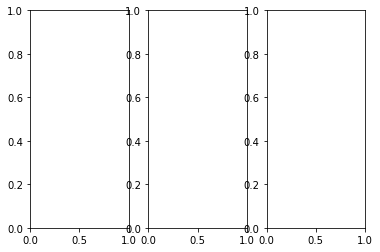

In [33]:
thumbnail_data = []

# url = azure_cog_urls[0]
for url in image_urls:
    
    # From:
    #
    # https://automating-gis-processes.github.io/CSC/notebooks/L5/read-cogs.html
    with rasterio.open(url) as raster:
        
        # List of overviews from biggest to smallest
        oviews = raster.overviews(1)
    
        # Retrieve the smallest thumbnail
        decimation_level = oviews[-1]
        h = int(raster.height/decimation_level)
        w = int(raster.width/decimation_level)
        
        thumbnail_channel = raster.read(1, out_shape=(1, h, w))
        thumbnail_data.append(thumbnail_channel)

fig, axes = plt.subplots(1, 3)

for i,d in enumerate(thumbnail_data):
    axes[i].imshow(d)

### Choose one image file to render

In [38]:
url = None
for s in image_urls:
    if image_type in s:
        url = s
        break
assert url is not None 
print('Rendering image:\n{}'.format(url))

Rendering image:
https://astersa.blob.core.windows.net/aster/images/L1T/2002/10/04/AST_L1T_00310042002014048_20150425134514_6769.VNIR.tif


### Make an RGB composite

Tile is 5725 x 5119
0


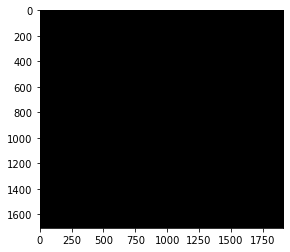

In [54]:
# Downscaling factor used when rendering whole-tile composite
dsfactor = 3

# Bands to use for RGB composite
bands = [3,2,1]

# Normalization value per channel
norm_value_composite = [100,100,100]
norm_value_composite = [1,1,1]

image_data = []

with rasterio.open(url,'r') as src:
    
    h = int(src.height//dsfactor)
    w = int(src.width//dsfactor)
    
    print('Tile is {} x {}'.format(src.width,src.height))

    assert src.count >= len(bands)
    
    for i,band in enumerate(bands):
        band_array = src.read(band, out_shape=(1, h, w))
        band_array = band_array # / norm_value_composite[i]
        image_data.append(band_array)
    src.close()
        
rgb = np.dstack((image_data[0],image_data[1],image_data[2]))
# np.clip(rgb,0,1,rgb)
plt.imshow(rgb)  
print(np.max(image_data[2]))

In [ ]:
# An ASTER RGB composite recommendation I found in this paper, which has really pretty figures:
#
# Bakardjiev D, Popov K. ASTER spectral band ratios for detection of hydrothermal alterations and ore
# deposits in the Panagyurishte Ore Region, Central Srednogorie, Bulgaria. Review of the Bulgarian
# Geological Society. 2015 Jan 1;76(part 1):79-88.
#
rgb_bands = ['ImageData12','ImageData3N','ImageData5']

# First resample all three channels to the same size, since they may have
# come from different sensors.
x_sizes = [(all_bands[b].shape[0]) for b in rgb_bands]
min_x_index = x_sizes.index(min(x_sizes))

target_x_size = all_bands[rgb_bands[min_x_index]].shape[0]
target_y_size = all_bands[rgb_bands[min_x_index]].shape[1]

resized_band_values = []
for i_band,band_name in enumerate(rgb_bands):
    d = all_bands[band_name]
    resized_d = cv2.resize(d, dsize=(target_x_size, target_y_size), interpolation=cv2.INTER_CUBIC)
    # Normalize each band
    resized_d = resized_d / np.max(resized_d)
    resized_band_values.append(resized_d)

rgb = np.dstack((resized_band_values[0],resized_band_values[1],resized_band_values[2]))
np.clip(rgb,0,1,rgb)
plt.imshow(rgb)

### Clean up temporary files

In [ ]:
shutil.rmtree(temp_dir)